In [1]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import random
import os
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# DATASET_PATH="Data/"
# TRAIN_PATH=  "Data/train/"
# TEST_PATH= "Data/test/"


import os

data_folder = "Data" 

# Function to get image paths in a specific folder
def get_image_paths(folder_path):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(".jpg"):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
    return image_paths

# Paths to train images
train_normal = get_image_paths(os.path.join(data_folder, "train", "NORMAL"))
train_covid19 = get_image_paths(os.path.join(data_folder, "train", "COVID19"))
train_pneumonia = get_image_paths(os.path.join(data_folder, "train", "PNEUMONIA"))

# Paths to test images
test_normal = get_image_paths(os.path.join(data_folder, "test", "NORMAL"))
test_covid19 = get_image_paths(os.path.join(data_folder, "test", "COVID19"))
test_pneumonia = get_image_paths(os.path.join(data_folder, "test", "PNEUMONIA"))

# Combine into train and test variables
train = {
    "NORMAL": train_normal,
    "COVID19": train_covid19,
    "PNEUMONIA": train_pneumonia
}

test = {
    "NORMAL": test_normal,
    "COVID19": test_covid19,
    "PNEUMONIA": test_pneumonia
}

# Example usage
print("Train:")
for category, paths in train.items():
    print(f"{category}: {len(paths)} images")

print("\nTest:")
for category, paths in test.items():
    print(f"{category}: {len(paths)} images")


Train:
NORMAL: 1266 images
COVID19: 460 images
PNEUMONIA: 3418 images

Test:
NORMAL: 317 images
COVID19: 116 images
PNEUMONIA: 855 images


In [4]:
import pandas as pd


# Create a DataFrame for the train set
train_data = []

for label, paths in train.items():
    for path in paths:
        train_data.append({"image_path": path, "label": label})

train_df = pd.DataFrame(train_data)

# Create a DataFrame for the test set
test_data = []

for label, paths in test.items():
    for path in paths:
        test_data.append({"image_path": path, "label": label})

test_df = pd.DataFrame(test_data)

# Encode labels
label_encoder = {"COVID19": 0, "NORMAL": 1, "PNEUMONIA": 2}

train_df["label_encoded"] = train_df["label"].map(label_encoder)
test_df["label_encoded"] = test_df["label"].map(label_encoder)

# Use frac, random_state, and reset_index for train DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Use frac, random_state, and reset_index for test DataFrame
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Example usage
print("Train DataFrame:")
print(train_df.head())

print("\nTest DataFrame:")
print(test_df.head())


Train DataFrame:
                                 image_path      label  label_encoded
0   Data\train\PNEUMONIA\PNEUMONIA(829).jpg  PNEUMONIA              2
1  Data\train\PNEUMONIA\PNEUMONIA(2424).jpg  PNEUMONIA              2
2  Data\train\PNEUMONIA\PNEUMONIA(1452).jpg  PNEUMONIA              2
3    Data\train\PNEUMONIA\PNEUMONIA(52).jpg  PNEUMONIA              2
4         Data\train\NORMAL\NORMAL(422).jpg     NORMAL              1

Test DataFrame:
                                image_path      label  label_encoded
0  Data\test\PNEUMONIA\PNEUMONIA(4105).jpg  PNEUMONIA              2
1  Data\test\PNEUMONIA\PNEUMONIA(4170).jpg  PNEUMONIA              2
2  Data\test\PNEUMONIA\PNEUMONIA(3447).jpg  PNEUMONIA              2
3        Data\test\NORMAL\NORMAL(1347).jpg     NORMAL              1
4        Data\test\NORMAL\NORMAL(1329).jpg     NORMAL              1


In [5]:
class CFG:
    EPOCHS= 50
    BATCH_SIZE= 64
    SEED= 42
    TF_SEED= 768
    HEIGHT= 224
    WIDTH= 224
    CHANNELS= 3
    IMAGE_SIZE=(224,224,3)

In [6]:
from PIL import Image


def _load(image_path):
    # Read the image using PIL
    image_pil = Image.open(image_path)
    
    # Convert the image to a NumPy array
    image_np = np.array(image_pil)
    
    # Resize the image using PIL
    resized_image = Image.fromarray(image_np).resize((CFG.IMAGE_SIZE[0], CFG.IMAGE_SIZE[1]), resample=Image.LANCZOS)
    
    return resized_image


In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def view_sample(image, label, color_map='rgb', fig_size=(6, 4)):
    plt.figure(figsize=fig_size)
    
    if color_map == 'rgb':
        plt.imshow(np.array(image))
    else:
        grayscale_image = image.convert('L')  # Convert to grayscale using PIL
        plt.imshow(grayscale_image, cmap=color_map)
    
    plt.title(f'label: {label}', fontsize=16)
    return


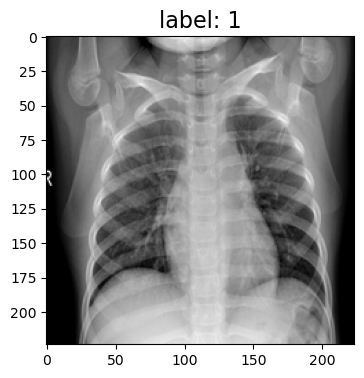

In [8]:
#select random sample from train_df
idx= random.sample(train_df.index.to_list(),1)[0]
#load the random sample and label
#sample_image, sample_label= _load(train_df.image_path[idx])
sample_image = _load(train_df.image_path[idx])
sample_label = train_df.label_encoded[idx]

#view the random sample colormap= gray
view_sample(sample_image, sample_label, color_map='gray')

In [9]:
def view_multiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count // 5
    if rows % 5 > 0:
        rows += 1
    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)
    
    for column, i in enumerate(idx):
        plt.subplot(rows, 5, column + 1)
        plt.title(f'Label: {df.label[i]}')
        
        loaded_image = sample_loader(df.image_path[i])
        if color_map == 'rgb':
            plt.imshow(np.array(loaded_image))
        else:
            grayscale_image = loaded_image.convert('L')  # Convert to grayscale using PIL
            plt.imshow(grayscale_image, cmap=color_map)
    
    return


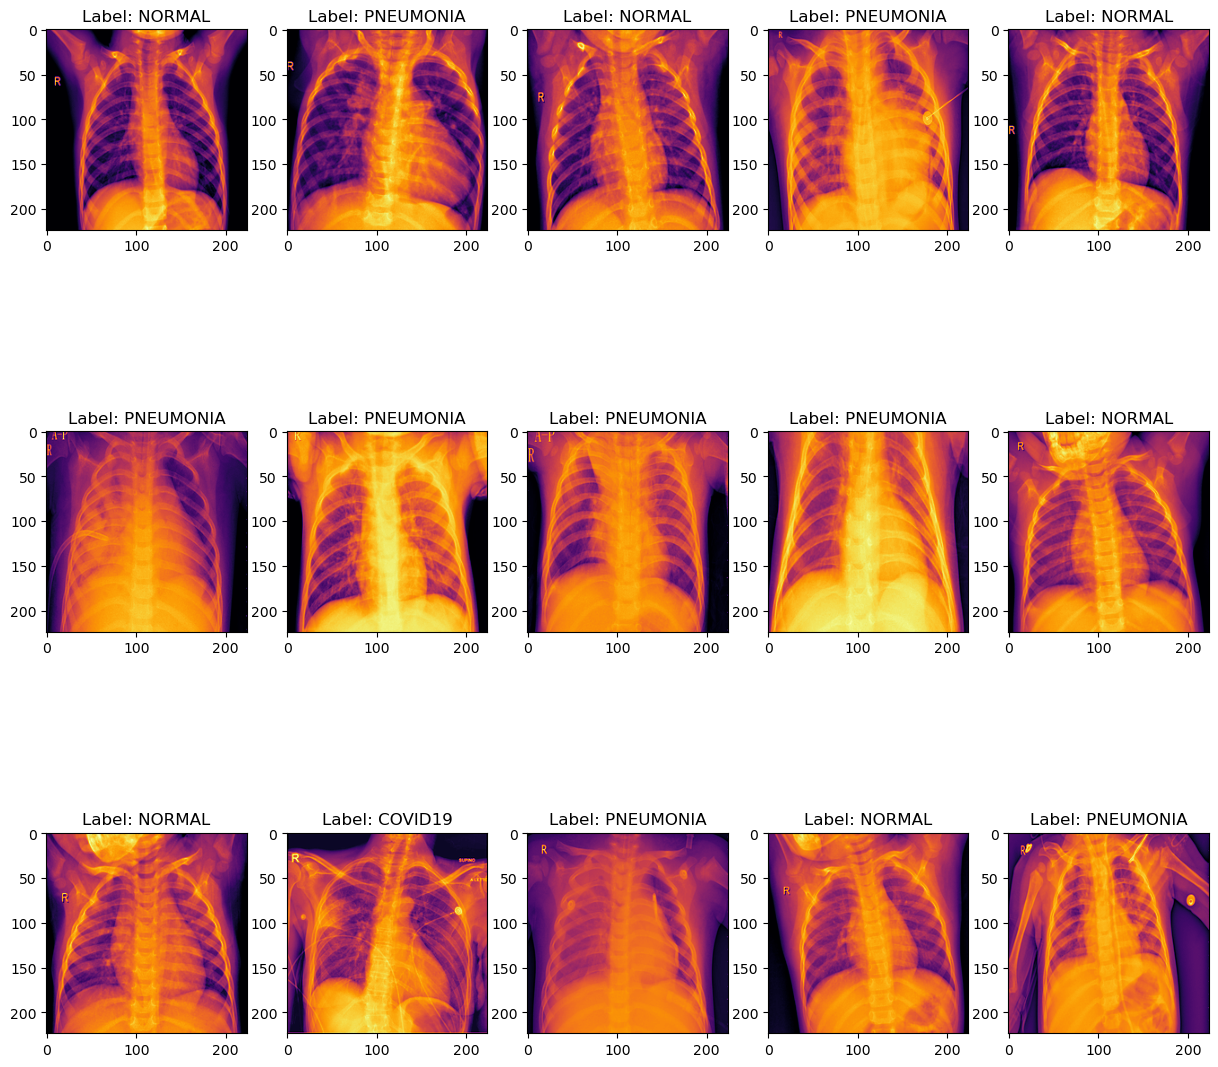

In [10]:
view_multiple_samples(train_df, _load, count=15, color_map='inferno', fig_size=(15,20))

In [11]:
from sklearn.model_selection import train_test_split


In [12]:
#create train/ val split with training
train_split_idx, val_split_idx,_,_= train_test_split(train_df.index,
                                                    train_df.label_encoded,
                                                    test_size= 0.15,
                                                    stratify=train_df.label_encoded,
                                                    random_state= CFG.SEED)

In [13]:

train_new_df= train_df.iloc[train_split_idx].reset_index(drop=True)
val_df= train_df.iloc[val_split_idx].reset_index(drop=True)
#view shape
train_new_df.shape, val_df.shape
train_new_df

,image_path,label,label_encoded
0,Data\train\PNEUMONIA\PNEUMONIA(1871).jpg,PNEUMONIA,2
1,Data\train\PNEUMONIA\PNEUMONIA(2404).jpg,PNEUMONIA,2
2,Data\train\PNEUMONIA\PNEUMONIA(335).jpg,PNEUMONIA,2
3,Data\train\PNEUMONIA\PNEUMONIA(1553).jpg,PNEUMONIA,2
4,Data\train\NORMAL\NORMAL(1152).jpg,NORMAL,1
...,...,...,...
4367,Data\train\PNEUMONIA\PNEUMONIA(1102).jpg,PNEUMONIA,2
4368,Data\train\PNEUMONIA\PNEUMONIA(3367).jpg,PNEUMONIA,2
4369,Data\train\NORMAL\NORMAL(1104).jpg,NORMAL,1
4370,Data\train\COVID19\COVID19(236).jpg,COVID19,0


Build an Augmentation layer

You can use data augmentation methods on your X-ray image data by building an augmentation layer . Adding more data is an important part of deep learning, especially when it comes to picture classification tasks, because it helps the model generalize better. To make this layer, you can use tools like TensorFlow (Keras) or PyTorch. These examples show how to use both frameworks:



In [19]:
import tensorflow as tf
from tensorflow.keras import layers,Sequential

#Build Augmentation layer
augmentation_layer= Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical',seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-.01,0.1),width_factor=(-0.1,0.1),seed=CFG.TF_SEED)
],name= 'augmentation_layer')

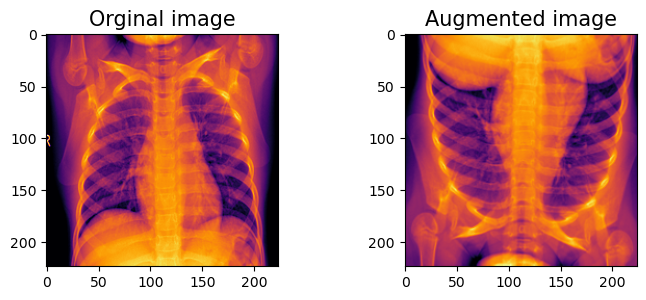

In [20]:
# Show inferno Augmented Image

image= tf.image.rgb_to_grayscale(sample_image)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,6))
#set spacing between subplot
fig.tight_layout(pad=6.0)
#view orginal image
ax1.set_title('Orginal image',fontsize=15)
ax1.imshow(image,cmap='inferno')
#view augmented image
ax2.set_title('Augmented image',fontsize=15)
ax2.imshow(augmentation_layer(image),cmap='inferno')

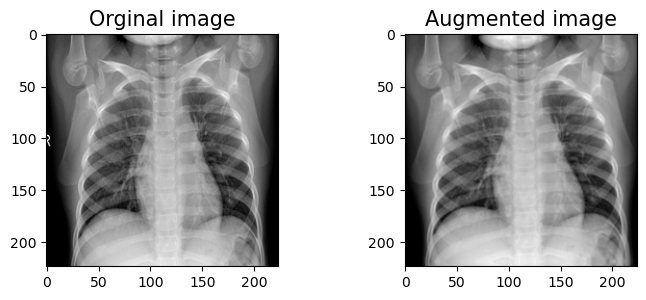

In [21]:
# Show Gray Augmented Image

image= tf.image.rgb_to_grayscale(sample_image)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,6))
#set spacing between subplot
fig.tight_layout(pad=6.0)
#view orginal image
ax1.set_title('Orginal image',fontsize=15)
ax1.imshow(image,cmap='gray')
#view augmented image
ax2.set_title('Augmented image',fontsize=15)
ax2.imshow(augmentation_layer(image),cmap='gray')

Step-7: Creating Pipeline for Transfer Learning¶
In Step 7, you will use a model that has already been taught to set up a pipeline for transfer learning. Transfer learning lets you use a neural network that has already been trained and adapt it to do what you do better. Using well-known deep learning tools like TensorFlow (Keras) and PyTorch, you can build the pipeline by following these steps:



In [23]:
train_new_df

,image_path,label,label_encoded
0,Data\train\PNEUMONIA\PNEUMONIA(1871).jpg,PNEUMONIA,2
1,Data\train\PNEUMONIA\PNEUMONIA(2404).jpg,PNEUMONIA,2
2,Data\train\PNEUMONIA\PNEUMONIA(335).jpg,PNEUMONIA,2
3,Data\train\PNEUMONIA\PNEUMONIA(1553).jpg,PNEUMONIA,2
4,Data\train\NORMAL\NORMAL(1152).jpg,NORMAL,1
...,...,...,...
4367,Data\train\PNEUMONIA\PNEUMONIA(1102).jpg,PNEUMONIA,2
4368,Data\train\PNEUMONIA\PNEUMONIA(3367).jpg,PNEUMONIA,2
4369,Data\train\NORMAL\NORMAL(1104).jpg,NORMAL,1
4370,Data\train\COVID19\COVID19(236).jpg,COVID19,0


In [24]:
def encode_labels(labels,encode_depth=3):
    return tf.one_hot(labels,depth=encode_depth).numpy()
def create_pipeline(df,load_function,augment=False,batch_size=32,shuffle=False,cache=None,prefetch=False):
    #get image path and labels from data_frame
    image_paths= df.image_path
    image_labels= encode_labels(df.label_encoded)
    AUTOTUNE= tf.data.AUTOTUNE
    #Create dataset with raw data from data frame
    ds= tf.data.Dataset.from_tensor_slices((image_paths,image_labels))
    #map augmentation layer and load function to dataset input if augment is true
    if augment:
        ds=ds.map(lambda x,y: (augmentation_layer(load_function(x)),y),num_parallel_calls= AUTOTUNE)
    else:
        ds= ds.map(lambda x,y: (load_function(x),y),num_parallel_calls= AUTOTUNE)
    #Applying shuffing based on condion
    if shuffle:
        ds= ds.shuffle(buffer_size=1000)
    #applying batching
    ds= ds.batch(batch_size)
    #applying caching based on condion
    if cache!=None:
        ds= ds.cache(cache)
    if prefetch:
        ds= ds.prefetch(buffer_size= AUTOTUNE)
    return ds

In [25]:
def _load(image_path):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode the image to a uint8 tensor
    image = tf.io.decode_image(image, channels=3)
    # Ensure the image has a known shape
    image.set_shape([CFG.HEIGHT, CFG.WIDTH, 3])
    # Resize the image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH], method=tf.image.ResizeMethod.LANCZOS3)
    return image

In [27]:
#Creating Training Pipeline
train_ds= create_pipeline(train_new_df,_load,
                         augment= True,
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= True)

In [29]:
#Creating Test Pipeline
test_ds= create_pipeline(test_df,_load,
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= False)

In [30]:
#Creating Validation Pipeline
val_ds= create_pipeline(val_df,_load,
                         
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= False)

In [31]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Step-8: Design and Develop Custom CNN Model ¶
In Step 8, you will create a unique Convolutional Neural Network (CNN) model for your X-ray picture categorization challenge. This customized CNN model will be developed from the bottom up without using a pre-trained model. Here's how to create your own CNN model with popular deep learning frameworks like TensorFlow (Keras) and PyTorch:

In [32]:
def cnn_model():
    initializer= tf.keras.initializers.GlorotNormal()
    cnn_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2,padding='valid'),
        
        
        layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax', kernel_initializer=initializer), 
    ], name='cnn_sequential_model')
    return cnn_sequential

In [33]:
def cnn_model16():
    initializer= tf.keras.initializers.GlorotNormal()
    cnn_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2,padding='valid'),
        
        
        layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
         layers.Conv2D(4,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(4,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax', kernel_initializer=initializer), 
    ], name='cnn_sequential_model')
    return cnn_sequential

In [34]:
# Create an instance of the model
model_cnn = cnn_model()
model_cnn.summary()


Model: "cnn_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 8)       1160      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 8)         0         
 g2D)                                        

C:\Users\shpctac1000a\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Step-9: Training and Validating Custom CNN Model ¶
In Step 9, you will train and test your unique Convolutional Neural Network (CNN) model for classifying X-ray images. Training and validating the model are very important parts of the model creation process. I'll show you how to use popular deep learning tools like TensorFlow (Keras) and PyTorch to train and test your model below:

In [35]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, tf_valid_data=None, shuffling= True):
    model_history={}
    if tf_valid_data!=None:
        model_history= model.fit(tf_train_data,
                                 epochs= num_epochs,
                                 validation_data= tf_valid_data,
                                 validation_steps= int(len(tf_valid_data)),
                                 callbacks= callbacks_list,
                                 shuffle= shuffling
                                )
    if tf_valid_data==None:
        model_history= model.fit(tf_train_data,
                                 epochs= num_epochs,
                                 callbacks= callbacks_list,
                                 shuffle= shuffling
                                )
    return model_history

In [36]:
early_stopping_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=5,
                                                         verbose=1,
                                                         restore_best_weights=True)

reduce_lr_callback= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                        patience=3,
                                                        factor=0.1,
                                                        verbose=1)

CALLBACKS=[early_stopping_callback, reduce_lr_callback]
METRICS=['accuracy']

In [39]:
tf.random.set_seed(CFG.SEED)
model_cnn.compile(loss='categorical_crossentropy',
                 optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                 metrics=METRICS)

print(f'training{model_cnn.name}.')
print(f'Train On: {len(train_new_df)} samples, validate On: {len(val_df)} samples.')
print('----------------------------------------------------------')
cnn_history= train_model(model_cnn, CFG.EPOCHS, CALLBACKS, train_ds, val_ds, shuffling=True)

model_cnn.save("Trained Model/xray.h5")

trainingcnn_sequential_model.
Train On: 4372 samples, validate On: 772 samples.
----------------------------------------------------------
Epoch 1/50
69/69 [==============================] - 11s 149ms/step - loss: 0.6448 - accuracy: 0.7168 - val_loss: 0.6300 - val_accuracy: 0.7176 - lr: 1.0000e-04
Epoch 2/50
69/69 [==============================] - 10s 150ms/step - loss: 0.6030 - accuracy: 0.7118 - val_loss: 0.6172 - val_accuracy: 0.7228 - lr: 1.0000e-04
Epoch 3/50
69/69 [==============================] - 10s 147ms/step - loss: 0.5947 - accuracy: 0.7157 - val_loss: 0.5998 - val_accuracy: 0.7383 - lr: 1.0000e-04
Epoch 4/50
69/69 [==============================] - 10s 147ms/step - loss: 0.5792 - accuracy: 0.7235 - val_loss: 0.6645 - val_accuracy: 0.7383 - lr: 1.0000e-04
Epoch 5/50
69/69 [==============================] - 10s 148ms/step - loss: 0.5642 - accuracy: 0.7269 - val_loss: 0.6068 - val_accuracy: 0.7474 - lr: 1.0000e-04
Epoch 6/50
69/69 [==============================] - 10s 148ms

In [40]:
cnn_evaluatiion= model_cnn.evaluate(test_ds)

21/21 [==============================] - 1s 49ms/step - loss: 0.4536 - accuracy: 0.7764


In [42]:
# Model loading
from tensorflow.keras.models import load_model


model=load_model('Trained Model/xray.h5')

Now Predictions for random image¶


In [50]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input


img= image.load_img("Data/test/PNEUMONIA/PNEUMONIA(3438).jpg",target_size=(224,224))

x= image.img_to_array(img)
x=x/255
x= np.expand_dims(x, axis=0)
img_data=preprocess_input(x)
img_data.shape
preds= model.predict(x)
preds= np.argmax(preds, axis=1)

if preds==0:
    preds="The image is Covid19"
elif preds==1:
    preds="The image is NORMAL"
else:
    preds="The image is Pneumonia"
print(preds)

1/1 [==============================] - 0s 21ms/step
The image is Covid19


In [51]:
cnn_test_probabilities=model_cnn.predict(test_ds, verbose=1)
cnn_test_predictions= tf.argmax(cnn_test_probabilities, axis=1)

21/21 [==============================] - 1s 50ms/step


In [52]:
cnn_test_probabilities

array([[3.0007818e-01, 2.4428706e-01, 4.5563477e-01],
       [1.0576674e-06, 1.8451071e-07, 9.9999869e-01],
       [1.4238632e-05, 1.7886159e-03, 9.9819714e-01],
       ...,
       [1.7197425e-09, 1.1090322e-10, 1.0000000e+00],
       [6.8820975e-07, 7.0527506e-07, 9.9999857e-01],
       [4.3214157e-02, 4.9797288e-01, 4.5881298e-01]], dtype=float32)

Step-10: Now Plot the Training Loss, Validation Loss, Training Accuracy, Validation Accuracy ¶
Step 10 lets you map the training loss, validation loss, training accuracy, and validation accuracy to see how well your custom CNN model is doing while it is being trained. To make these plots, you can use Python tools like Matplotlib. Here are some examples of how to make these plots with TensorFlow (Keras) and PyTorch, two famous deep learning frameworks:

In [54]:
import numpy as np

def plot_training_curves(history):
    loss= np.array(history.history['loss'])
    val_loss= np.array(history.history['val_loss'])
    
    accuracy= np.array(history.history['accuracy'])
    val_accuracy= np.array(history.history['val_accuracy'])
    
    epochs= range(len(history.history['loss']))
    
    fig, (ax1, ax2)= plt.subplots(1,2,figsize=(10,3))
    
    #plot loss
    ax1.plot(epochs, loss, label='traing_loss', marker='o')
    
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs,loss, val_loss, where=(loss>val_loss),color='C0',alpha=0.3,interpolate=True)
    ax1.fill_between(epochs,loss, val_loss, where=(loss<val_loss),color='C1',alpha=0.3,interpolate=True)
    
    ax1.set_title('Loss(Lower Means Better)',fontsize= 16)
    ax1.set_xlabel('Epochs', fontsize=10)
    
    ax1.legend()
    
    #plot Accuracy
    ax2.plot(epochs, accuracy, label='traing_accuracy', marker='o')
    
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy>val_accuracy),color='C0',alpha=0.3,interpolate=True)
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy<val_accuracy),color='C1',alpha=0.3,interpolate=True)
    
    ax2.set_title('Accuracy(Higher Means Better)',fontsize= 16)
    ax2.set_xlabel('Epochs', fontsize=10)
    
    ax2.legend()

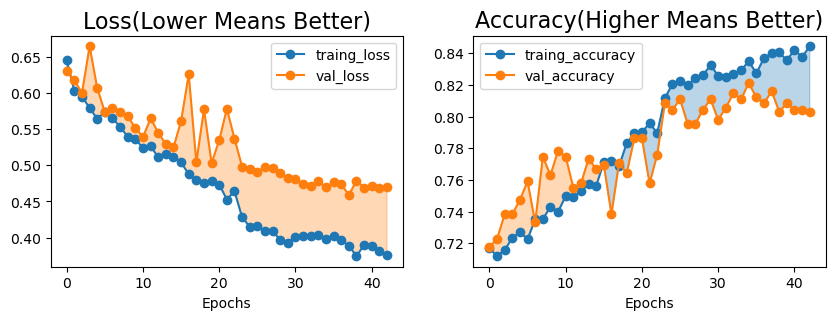

In [55]:
plot_training_curves(cnn_history)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the ConvNeXt block
def conv_next_block(inputs, filters, dropout_rate=0.):
    x = layers.Conv2D(filters, kernel_size=7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    return layers.Add()([inputs, x])

# Build the ConvNeXt model
def build_convnext_model(input_shape, num_classes, depths, dim, dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(dim, kernel_size=4, strides=4, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)

    for depth in depths:
        x = conv_next_block(x, dim, dropout_rate)
        for _ in range(depth):
            x = conv_next_block(x, dim, dropout_rate)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Assuming you have already created the data pipelines: train_ds, val_ds, test_ds

# Define the ConvNeXt model
input_shape = (CFG.HEIGHT, CFG.WIDTH, CFG.CHANNELS)
num_classes = 3  # Number of classes (COVID19, NORMAL, PNEUMONIA)
depths = [3, 3, 9, 3]  # Depth configuration for ConvNeXt
dim = 96  # Dimension of the model

model = build_convnext_model(input_shape, num_classes, depths, dim)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=CFG.EPOCHS,
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')